## Analyzing generated dataset

### Import data

In [51]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

from importlib import reload
import analysis_util
import util
reload(analysis_util)
reload(util)

from analysis_util import analyze_outliers, plot_value_distributions, analyze_sequences, analyze_syntax_tokens, plot_values
from util import load_dataset, create_dataloader
import pandas as pd
import numpy as np
import torch

In [49]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath, 'dataset_240817_2')

def value_transform(x):
    return torch.arcsinh(x)/10  # Example transformation

val_transformed = value_transform(torch.tensor(val)).detach().numpy()

In [52]:
### Alternatively: Load subset of training data according to DataLoader
torch.manual_seed(41)
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', test_split=1/4, batch_size=64, value_transform=value_transform, device='cpu')
all_x, all_y_syn, all_y_const, all_y_val = next(iter(train_loader))

syntax = all_x[:, :-1, :].detach().numpy().transpose(0, 2, 1)
consts = all_x[:, -1, :].squeeze().detach().numpy()
val = all_y_val

# val_transformed = value_transform(val).detach().numpy()

### Calculate priors

In [61]:
calc_priors_and_means(train_loader)

({'syntax_prior': np.float32(1.3988278),
  'consts_prior': np.float32(0.06453593),
  'values_prior': tensor(0.0648)},
 {'consts_mean': array([ 0.        , -0.00106831, -0.00165839, -0.00195638, -0.00322012,
         -0.00056191, -0.00155325,  0.00113474,  0.00219962,  0.00117332,
          0.00027576,  0.        ,  0.        ,  0.        ,  0.        ],
        dtype=float32),
  'values_mean': tensor([-0.0055, -0.0067, -0.0084, -0.0075, -0.0088, -0.0103, -0.0111, -0.0124,
          -0.0129, -0.0135, -0.0135, -0.0137, -0.0134, -0.0134, -0.0127, -0.0120,
          -0.0104, -0.0092, -0.0071, -0.0079, -0.0061, -0.0036, -0.0023, -0.0010,
           0.0003,  0.0005,  0.0009,  0.0013,  0.0006, -0.0002, -0.0008, -0.0017,
          -0.0031, -0.0044, -0.0031, -0.0047, -0.0059, -0.0069, -0.0076, -0.0077,
          -0.0076, -0.0071, -0.0062, -0.0050, -0.0033, -0.0011,  0.0015,  0.0053,
           0.0098,  0.0149,  0.0329,  0.0372,  0.0434,  0.0493,  0.0546,  0.0589,
           0.0621,  0.0656,  0.

In [47]:
# Calculate cross entropy prior for syntax
prod_counts = pd.Series(syntax.argmax(axis=-1).flatten()).value_counts()
p = prod_counts / prod_counts.sum()
cross_entropy_prior = -np.sum(p * np.log(p)).astype(np.float32)
print(f'\n{cross_entropy_prior = }')

# Calculate MSE prior for constants
mse_prior_consts = consts.flatten().var()
consts_bias = consts.flatten().mean()
print(f'{mse_prior_consts = }')

# Calculate MSE prior for values
mse_prior_values = val_transformed.var()
val_transformed_bias = val_transformed.mean()
print(f'{mse_prior_values = }')


print(f'\n{consts_bias = }')
print(f'{val_transformed_bias = }')  # Could be used to init bias in final layer of value decoder (c.f. Karpathy blog)


cross_entropy_prior = np.float32(1.3984073)
mse_prior_consts = np.float32(0.06433585)
mse_prior_values = np.float32(0.06500606)

consts_bias = np.float32(-0.00021629629)
val_transformed_bias = np.float32(0.051285654)


### Analyze dataset

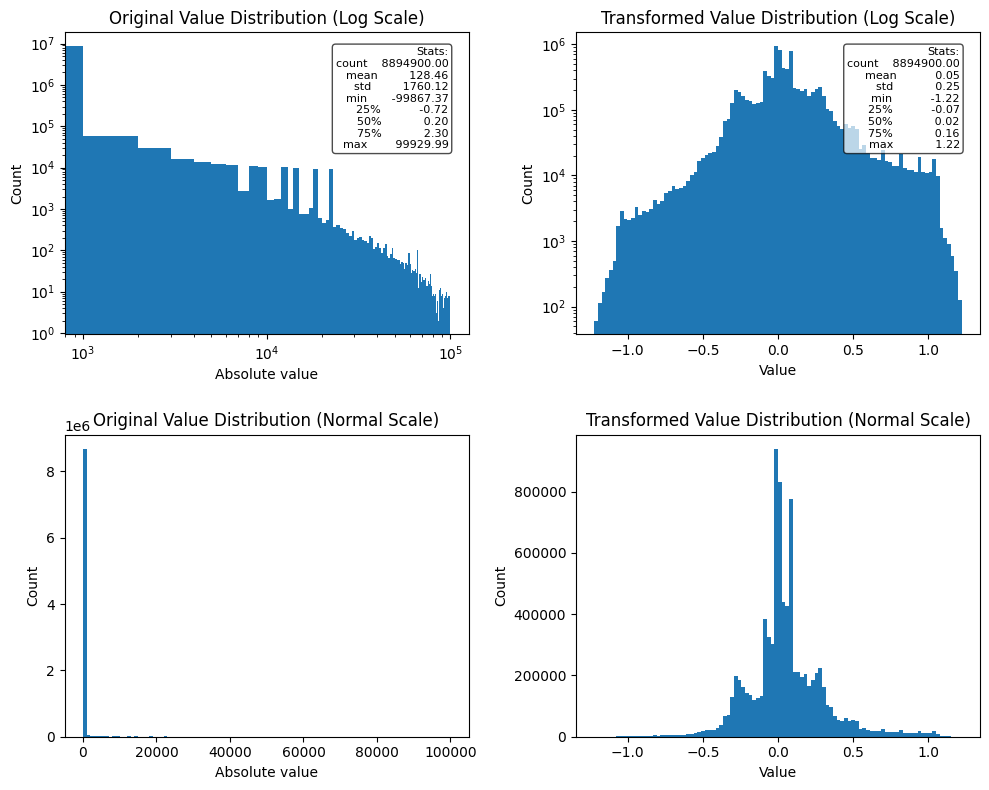

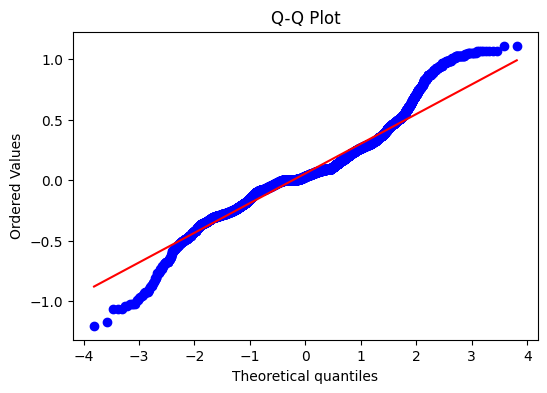

Number of outliers detected using z-score method: 193308
Number of outliers detected using IQR method: 685189


In [10]:
plot_value_distributions(val, val_transformed)
analyze_outliers(val_transformed)

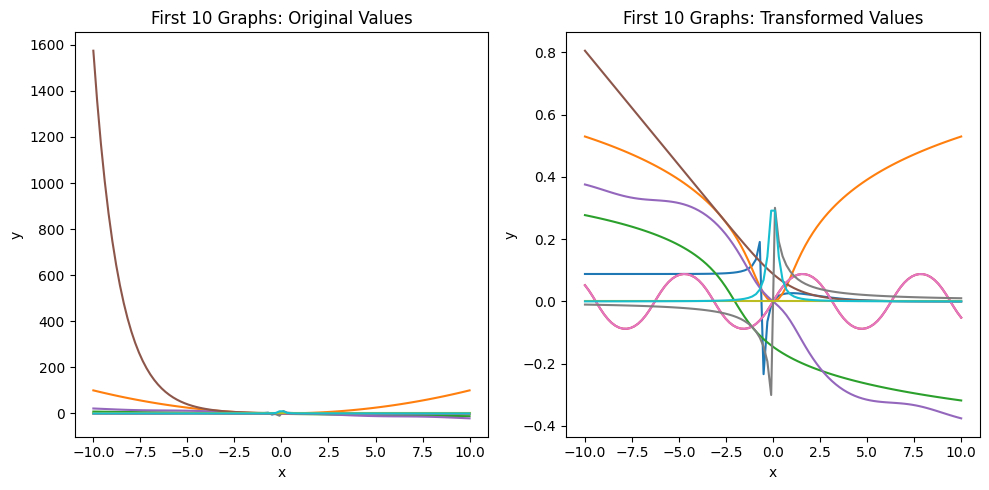

In [11]:
plot_values(val_x, val, val_transformed, idx=np.arange(10))

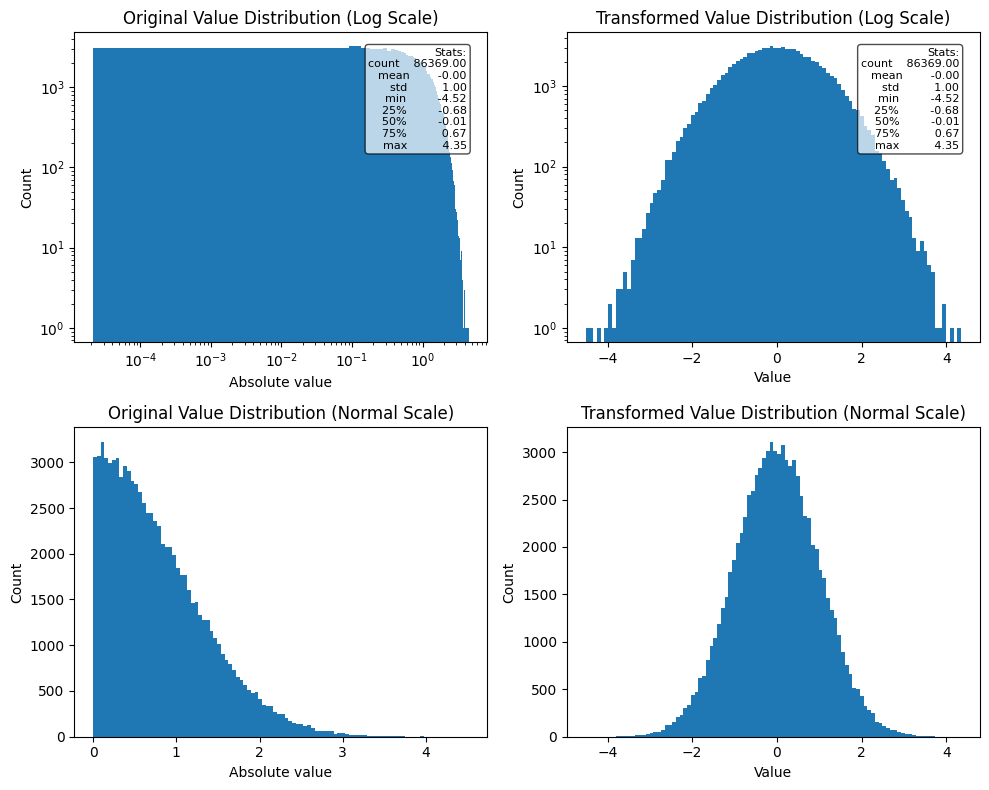

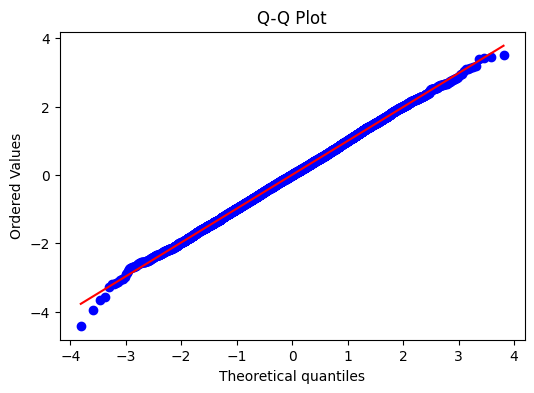

Number of outliers detected using z-score method: 228
Number of outliers detected using IQR method: 591


In [24]:
mask = (syntax[:, :, syntax_cats.index('CON')] == 1)
active_consts = consts[mask]

plot_value_distributions(active_consts, active_consts)
analyze_outliers(active_consts)

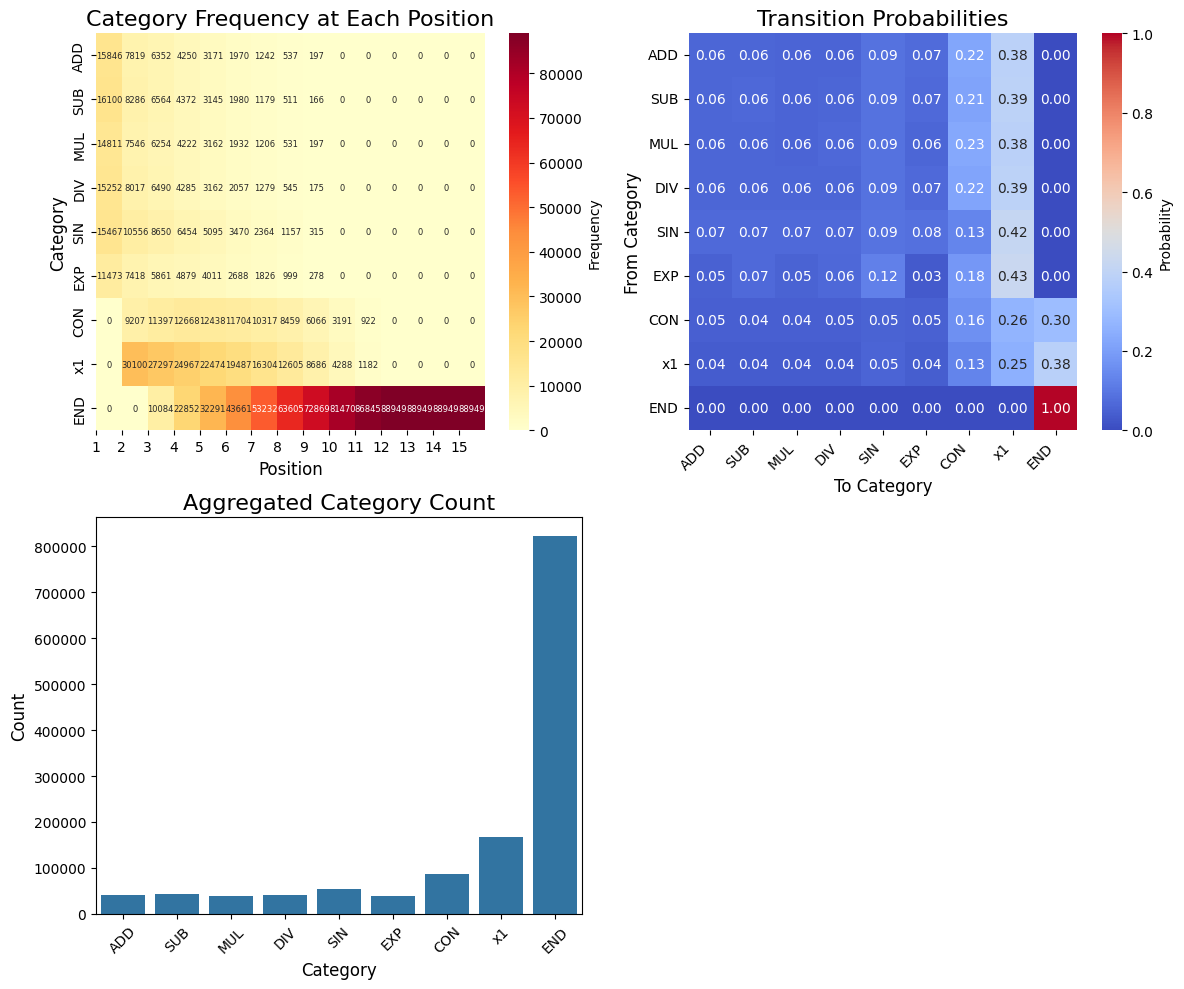

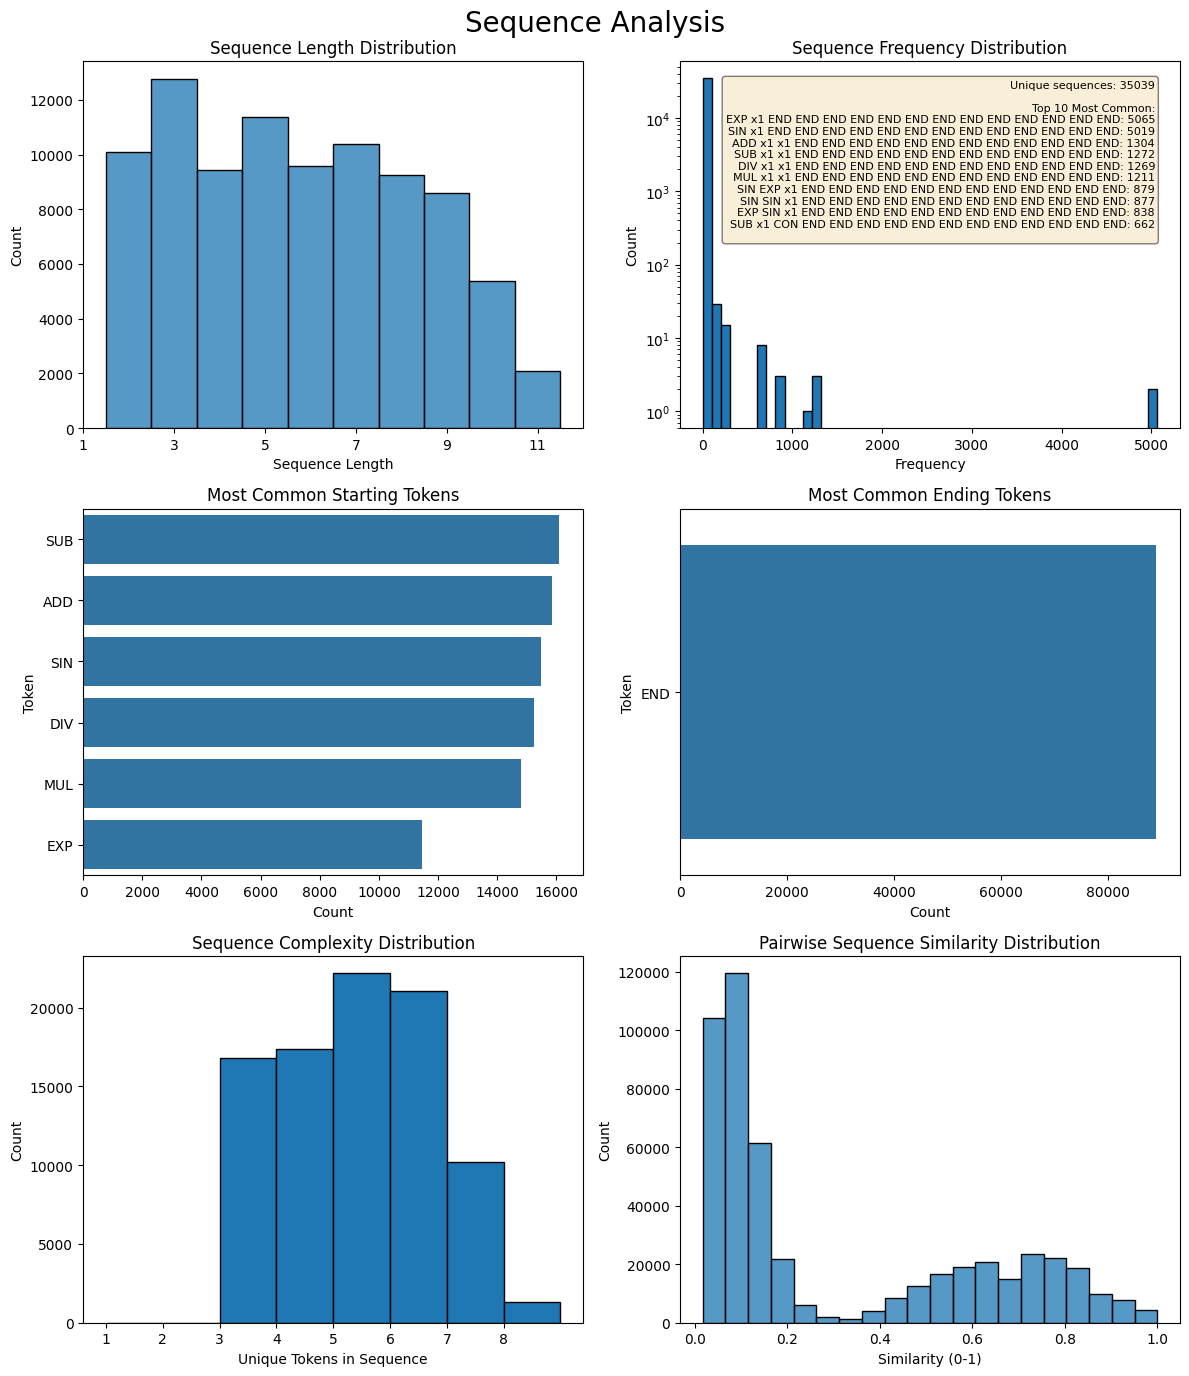

In [49]:
analyze_syntax_tokens(syntax, syntax_cats)
analyze_sequences(syntax, syntax_cats)